In [ ]:
from transformers import PreTrainedModel
from transformers import BlipForImageTextRetrieval, BlipProcessor, PretrainedConfig
import torch
class Rater(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.backbone = backbone    

    def forward(self, pixel_values, input_ids, attention_mask, n_images, labels=None):
        outputs = self.backbone(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
        if labels is not None:
            raise RuntimeError("let it crash: labels not supported in this benchmark")
        return outputs

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
backbone = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco", torch_dtype=torch.float16).to("cuda:2")
rater_config = PretrainedConfig.from_pretrained("weathon/BLIP-Reward")
rater = Rater(rater_config).to("cuda:2") 

In [3]:
import json
with open("prompts.json", "r") as file:
    prompt_dict = json.load(file)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark", split="train")

In [5]:
dataset

Dataset({
    features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
    num_rows: 3300
})

In [10]:
def rate_sample(sample):
    original_rater = {}
    distorted_rater = {}
    for dim in prompt_dict.keys():
        prompt = prompt_dict[dim]
        inputs = processor(images=[sample["image_original"], sample["image_distorted"]], text=[prompt, prompt], return_tensors="pt", padding=True).to("cuda:2")
        with torch.no_grad(): 
            outputs = rater(**inputs, n_images=[2]) 
        scores = torch.softmax(outputs["itm_score"], dim=-1)[:, 1]
        original_rater[dim] = scores[0].item()
        distorted_rater[dim] = scores[1].item()
    return {
        "original": original_rater,
        "distorted": distorted_rater
    }

In [23]:
import pprint

{'background': 0.09051513671875,
 'clarity': 0.000583648681640625,
 'color aesthetic': 0.00881195068359375,
 'color brightness': 0.01837158203125,
 'detail realism': 0.00335693359375,
 'detail refinement': 0.0582275390625,
 'emotion': 0.0099334716796875,
 'lighting distinction': 0.0305938720703125,
 'main object': 0.1458740234375,
 'object pairing': 0.01073455810546875,
 'richness': 0.09075927734375,
 'symmetry': 0.026580810546875}



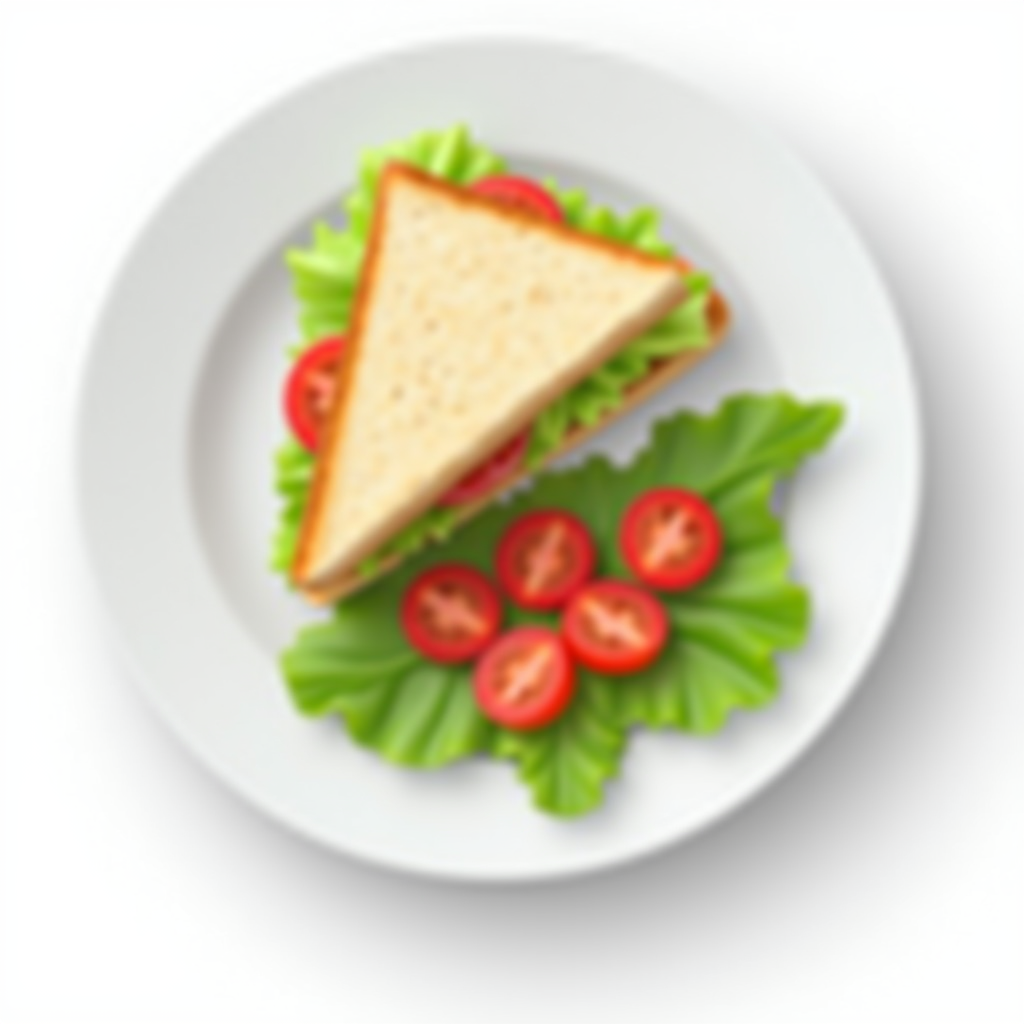

In [ ]:
pprint.pprint(rate_sample(dataset[937])["distorted"])
print() 
dataset[937]["image_distorted"] 
